### Import library

In [39]:
import re
import csv
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy 
import spacy
from spacy import displacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

### Import data

In [108]:
with open('data/allNews_30%sample_lemmatized.csv') as csvfile:
    reader1 = csv.reader(csvfile)
df = pd.read_csv('data/allNews_30%sample_lemmatized.csv',sep='\t')

In [33]:
df = pd.read_pickle("data/allNews_1%sample_lemmatized.pkl")

### Create the Dictionary and Corpus needed for Topic Modeling

The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [34]:
# Create Dictionary
id2word = corpora.Dictionary(df.content.tolist())

# Create Corpus
texts = df.content.tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 3), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 7), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 2), (65, 2), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 5), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 1), (109, 1), (110, 1)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 14 occurs three times and so on. This is used as the input by the LDA model. To see what word a given id corresponds to, pass the id as a key to the dictionary.

In [35]:
id2word[0]

'ability'

You can see a human-readable form of the corpus itself.

In [36]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('accomplished', 1),
  ('acknowledge', 1),
  ('address', 1),
  ('adviser', 1),
  ('advocacy', 1),
  ('aim', 1),
  ('aloud', 1),
  ('andrea', 1),
  ('angela_merkel', 1),
  ('answer', 1),
  ('anything', 1),
  ('appearance', 1),
  ('attitude', 1),
  ('audible', 1),
  ('audience', 3),
  ('barely', 1),
  ('begin', 1),
  ('behavior', 1),
  ('belief', 1),
  ('berlin', 2),
  ('boo', 3),
  ('browser', 1),
  ('business', 2),
  ('campaign', 1),
  ('care', 1),
  ('certainly', 1),
  ('champion', 1),
  ('christine', 1),
  ('clip', 1),
  ('come', 1),
  ('comment', 1),
  ('compel', 1),
  ('conference', 1),
  ('conviction', 1),
  ('convince', 1),
  ('country', 1),
  ('criticism', 1),
  ('crowd', 1),
  ('daily', 1),
  ('daughter', 2),
  ('decade', 1),
  ('defense', 1),
  ('derisive', 1),
  ('die', 1),
  ('director', 1),
  ('display', 1),
  ('editor', 2),
  ('elect', 1),
  ('election', 1),
  ('elicit', 1),
  ('empowerer', 1),
  ('enable', 1),
  ('equality', 1),
  ('even', 1),
  ('expe

### Building the Topic Model

We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [42]:
import warnings
warnings.filterwarnings('ignore')
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [43]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"say" + 0.010*"country" + 0.010*"government" + 0.009*"china" + '
  '0.008*"syria" + 0.007*"military" + 0.007*"would" + 0.007*"attack" + '
  '0.006*"official" + 0.006*"russia"'),
 (1,
  '0.013*"trump" + 0.012*"say" + 0.008*"would" + 0.007*"people" + 0.007*"make" '
  '+ 0.006*"think" + 0.006*"go" + 0.005*"time" + 0.005*"get" + 0.005*"may"'),
 (2,
  '0.023*"trump" + 0.016*"republican" + 0.016*"president" + 0.013*"obama" + '
  '0.013*"say" + 0.013*"would" + 0.010*"state" + 0.010*"law" + 0.009*"court" + '
  '0.007*"vote"'),
 (3,
  '0.024*"say" + 0.010*"company" + 0.008*"report" + 0.006*"year" + '
  '0.005*"would" + 0.005*"business" + 0.005*"new" + 0.005*"also" + '
  '0.005*"include" + 0.005*"state"'),
 (4,
  '0.014*"ship" + 0.007*"researcher" + 0.006*"science" + 0.006*"water" + '
  '0.006*"fire" + 0.006*"earth" + 0.005*"musashi" + 0.005*"scientist" + '
  '0.005*"land" + 0.005*"brain"'),
 (5,
  '0.023*"say" + 0.009*"go" + 0.009*"day" + 0.008*"get" + 0.007*"time" + '
  '0.007*"t

Topic 0 is a represented as _0.014"say" + 0.014"state" + 0.011"case" + 0.010"court" + 0.010"law" + 
  0.009"report" + 0.008"federal" + 0.007"school" + 0.007"department" + 0.006"student".

It means the top 10 keywords that contribute to this topic are: ‘say’, ‘state’, ‘case’.. and so on and the weight of ‘state’ on topic 0 is 0.014.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, we can guess what this topic could be, we may summarise the topic as 'law case about school'.

Likewise, we go through the remaining topic keywords and judge what the topic is.

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [44]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.474940925970682

Coherence Score:  0.3988296178919492


### Visualize the topics-keywords

Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [45]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.169853  0.099187       1        1  28.673182
3     -0.148982 -0.047578       2        1  16.970276
5     -0.110064  0.151736       3        1  14.162688
2     -0.141767 -0.147191       4        1  10.560461
7      0.002820  0.255989       5        1   8.274584
0     -0.086388 -0.180941       6        1   8.098122
6     -0.036544 -0.080299       7        1   6.228981
4      0.211363  0.034912       8        1   2.646963
8      0.179461 -0.038730       9        1   2.598367
9      0.299954 -0.047085      10        1   1.786377, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
155    Default  3192.000000           trump  3192.000000  30.0000  30.0000
129    Default  8299.000000             say  8299.000000  29.0000  29.0000
1381   Default   784.000000         percent   784.000000  28.0000  28.0000
2029   Default   959.000000      republican   959.000000  27.0000  27.0000
329    Default  1461.000000       president  1461.000000  26.0000  26.0000
1012   Default   959.000000         company   959.000000  25.0000  25.0000
1531   Default   831.000000           obama   831.000000  24.0000  24.0000
2845   Default   521.000000          police   521.000000  23.0000  23.0000
1938   Default   508.000000          muslim   508.000000  22.0000  22.0000
398    Default  2814.000000           would  2814.000000  21.0000  21.0000
1407   Default  1483.000000           state  1483.000000  20.0000  20.0000
293    Default   768.000000             law   768.000000  19.0000  19.0000
273    Default   996.000000      government   996.000000  18.0000  18.0000
81     Default   857.000000             man   857.000000  17.0000  17.0000
969    Default   408.000000             war   408.000000  16.0000  16.0000
166    Default   920.000000           woman   920.000000  15.0000  15.0000
829    Default  1072.000000          report  1072.000000  14.0000  14.0000
399    Default  1793.000000            year  1793.000000  13.0000  13.0000
36     Default  1138.000000         country  1138.000000  12.0000  12.0000
2450   Default   643.000000           court   643.000000  11.0000  11.0000
390    Default   616.000000            vote   616.000000  10.0000  10.0000
2498   Default   481.000000            kill   481.000000   9.0000   9.0000
169    Default   791.000000           world   791.000000   8.0000   8.0000
2671   Default   377.000000           china   377.000000   7.0000   7.0000
1685   Default   581.000000          attack   581.000000   6.0000   6.0000
245    Default   259.000000         economy   259.000000   5.0000   5.0000
2050   Default   394.000000          senate   394.000000   4.0000   4.0000
2190   Default   561.000000           cover   561.000000   3.0000   3.0000
774    Default  2349.000000          people  2349.000000   2.0000   2.0000
177    Default   542.000000  administration   542.000000   1.0000   1.0000
...        ...          ...             ...          ...      ...      ...
6625   Topic10    31.280197         tribute    32.140762   3.9978  -5.7042
27053  Topic10    30.402006         cologne    31.263968   3.9970  -5.7327
17730  Topic10    27.542223         elector    28.402298   3.9942  -5.8315
6879   Topic10    27.084681   ronald_reagan    27.945093   3.9937  -5.8482
6620   Topic10    26.023689         octopus    26.883797   3.9925  -5.8882
6006   Topic10    25.950254          priest    26.810591   3.9924  -5.8910
27583  Topic10    25.350992           ohler    26.211536   3.9916  -5.9144
28765  Topic10    25.117662           temer    25.978462   3.9913  -5.9236
7808   Topic10    24.387993        monument    25.248178   3.9903  -5.9531
29390  Topic10    24.250254          hamann    25.111177   3.9901  -5.9587
29393  Topic10    24.250254          nellie    25.111177   3.9901  -5.9587
22241  To

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

In [13]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [15]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=df.content.tolist(), dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('show', 0.01342473578977435),
   ('game', 0.008830810244691992),
   ('year', 0.0085213748452823),
   ('make', 0.008211939445872608),
   ('play', 0.007402646862801105),
   ('good', 0.006998000571265353),
   ('film', 0.005379415405122346),
   ('star', 0.005236599066933257),
   ('world', 0.00495096639055508),
   ('love', 0.004927163667523565)]),
 (1,
  [('law', 0.016783533137299255),
   ('state', 0.016738294503505995),
   ('federal', 0.013503732187287945),
   ('case', 0.01225966975797331),
   ('court', 0.01146799366659127),
   ('rule', 0.010925130061072156),
   ('government', 0.01058584030762271),
   ('order', 0.006876272336575435),
   ('act', 0.0066048405338158785),
   ('judge', 0.00651436326622936)]),
 (2,
  [('trump', 0.06174802565325701),
   ('republican', 0.02026465963498878),
   ('president', 0.01998197911697673),
   ('vote', 0.014540379145244784),
   ('campaign', 0.014240031094856982),
   ('obama', 0.012897298634299748),
   ('party', 0.011801911627003057),
   ('donald_trum

Just by changing the LDA algorithm, we increased the coherence score from . to . . Not bad!

### How to find the optimal number of topics for LDA

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df.content.tolist(), start=2, limit=25, step=3)

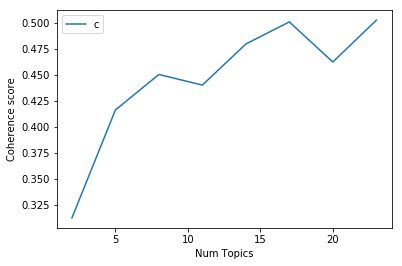

In [18]:
# Show graph
limit=26; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3124
Num Topics = 5  has Coherence Value of 0.416
Num Topics = 8  has Coherence Value of 0.4501
Num Topics = 11  has Coherence Value of 0.44
Num Topics = 14  has Coherence Value of 0.4794
Num Topics = 17  has Coherence Value of 0.5006
Num Topics = 20  has Coherence Value of 0.4621
Num Topics = 23  has Coherence Value of 0.5022


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with .. topics itself.

In [20]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.014*"people" + 0.009*"find" + 0.008*"study" + 0.008*"make" + '
  '0.008*"facebook" + 0.007*"research" + 0.006*"change" + 0.006*"work" + '
  '0.006*"problem" + 0.006*"program"'),
 (1,
  '0.017*"state" + 0.016*"law" + 0.014*"people" + 0.012*"bill" + '
  '0.012*"federal" + 0.012*"government" + 0.010*"rule" + 0.009*"american" + '
  '0.008*"court" + 0.008*"plan"'),
 (2,
  '0.011*"report" + 0.010*"official" + 0.010*"president" + 0.007*"clinton" + '
  '0.007*"claim" + 0.007*"white_house" + 0.007*"comment" + 0.007*"question" + '
  '0.007*"news" + 0.007*"office"'),
 (3,
  '0.006*"water" + 0.006*"city" + 0.006*"home" + 0.006*"fire" + 0.005*"move" + '
  '0.005*"building" + 0.005*"air" + 0.005*"run" + 0.005*"food" + 0.005*"part"'),
 (4,
  '0.013*"year" + 0.011*"day" + 0.009*"leave" + 0.008*"good" + 0.007*"time" + '
  '0.006*"play" + 0.006*"show" + 0.006*"game" + 0.005*"london" + '
  '0.005*"cover"'),
 (5,
  '0.021*"company" + 0.014*"percent" + 0.011*"business" + 0.011*"year" + '
  '0.010

Those were the topics for the chosen LDA model.

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.content.tolist()):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df.content.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.2173,"woman, people, man, student, school, family, b...","[ivanka, trump, trouble, convince, world, fath..."
1,1,5.0,0.2931,"company, percent, business, year, pay, job, ma...","[jar, regulatory, action, week, large, bank, b..."
2,2,3.0,0.4720,"water, city, home, fire, move, building, air, ...","[tale, planet, begin, years_ago, planet, earth..."
3,3,4.0,0.3641,"year, day, leave, good, time, play, show, game...","[british, costumer, sandy, powell, already, os..."
4,4,8.0,0.3511,"country, government, attack, military, war, fo...","[king_salman, push, aside, crown_prince, nayef..."
5,5,5.0,0.4802,"company, percent, business, year, pay, job, ma...","[dollar, steady, monday, recover, friday, loss..."
6,6,7.0,0.1703,"police, city, report, case, man, kill, accord,...","[thursday, sovereign, citizen, temporarily, en..."
7,7,2.0,0.3965,"report, official, president, clinton, claim, w...","[hillary_clinton, may, avoid, criminal_charge,..."
8,8,9.0,0.3905,"trump, republican, vote, president, campaign, ...","[come, house, democrat, retreat, friday, heap,..."
9,9,2.0,0.4381,"report, official, president, clinton, claim, w...","[document, release, friday, federal, bureau, i..."


### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7669,"people, find, study, make, facebook, research,...","[several, year, jack, gallant, neuroscience, l..."
1,1.0,0.7253,"state, law, people, bill, federal, government,...","[astonishing, thing, law, work, contain, flaw,..."
2,2.0,0.7324,"report, official, president, clinton, claim, w...","[follow, testimony, former, fbi_director, jame..."
3,3.0,0.7592,"water, city, home, fire, move, building, air, ...","[ground, earth, look, boundless, fertile, plai..."
4,4.0,0.6066,"year, day, leave, good, time, play, show, game...","[miami, heat, blueprint, knick, coach, jeff, h..."
5,5.0,0.6836,"company, percent, business, year, pay, job, ma...","[housing, start, fall, expect, march, permit, ..."
6,6.0,0.5583,"woman, people, man, student, school, family, b...","[new_orlean, louisiana, demonstration, tulane,..."
7,7.0,0.6293,"police, city, report, case, man, kill, accord,...","[day, arkansa, push, back, legal, challenge, c..."
8,8.0,0.7165,"country, government, attack, military, war, fo...","[istanbul, american, proxy, war, syria, offici..."
9,9.0,0.6610,"trump, republican, vote, president, campaign, ...","[republican, party, descent, civil_war, revive..."


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [30]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,6.0,"woman, people, man, student, school, family, b...",85.0,0.0596
1,5.0,"company, percent, business, year, pay, job, ma...",123.0,0.0863
2,3.0,"water, city, home, fire, move, building, air, ...",121.0,0.0849
3,4.0,"year, day, leave, good, time, play, show, game...",98.0,0.0687
4,8.0,"country, government, attack, military, war, fo...",108.0,0.0757
5,5.0,"company, percent, business, year, pay, job, ma...",153.0,0.1073
6,7.0,"police, city, report, case, man, kill, accord,...",113.0,0.0792
7,2.0,"report, official, president, clinton, claim, w...",149.0,0.1045
8,9.0,"trump, republican, vote, president, campaign, ...",156.0,0.1094
9,2.0,"report, official, president, clinton, claim, w...",206.0,0.1445
